# Multivariate Gaussian

## Background

### Probability Density Function

The pdf for the multivariate Gaussian distribution is given by:

$$f(\vec{x}|\vec{\mu}, \Sigma) = (2\pi)^{-\frac{k}{2}}\det(\Sigma)^{-\frac{1}{2}}e^{-\frac{1}{2}(\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu})}$$

where

$\vec{\mu} \in \mathbb{R}^{k}$ is the expected value vector

$\Sigma \in \mathbb{R}^{k \times k}$ is the covariance matrix

### Likelihood function

The likelihood function for a general distribution of independent random variables is defined as:

$$\mathcal{L}(\theta | \vec{x}) = \prod_{i = 1}^{n} f(x_{i}|\theta)$$

Thus, for the multivariate Gaussian:

$$\mathcal{L}(\vec{\mu}, \Sigma | \vec{x}) = (2\pi)^{-\frac{nk}{2}}\det(\Sigma)^{-\frac{n}{2}}e^{-\frac{1}{2}\sum_{i=1}^{n}(x_{i} - \vec{\mu})^{T}\Sigma^{-1}(x_{i}-\vec{\mu})}$$

Taking the natural logarithm of both sides:

$$l(\vec{\mu}, \Sigma) = -\frac{1}{2}[nk\ln(2\pi) + n\ln(\det(\Sigma^{-1})) + \sum_{i = 1}^{n}(\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu})]$$

Further, we can define the Mahalanobis distance between point $\vec{x}$ and the expected value vector $\vec{\mu}$

$$\text{MD}(\vec{x}|\vec{\mu}, \Sigma) = ((\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu}))^{\frac{1}{2}}$$

If we take the natural logarithm of the pdf, we have:

$$\ln(f(\vec{x}, \vec{\mu}, \Sigma) = -\frac{1}{2}[d\ln(2\pi) + \ln(\det(\Sigma^{-1})) + \text{MD}(\vec{x} | \vec{\mu}, \Sigma)^{2}]$$

Therefore, we can optimise for $\hat{\theta}$ and $\hat{\Sigma}$ by maximising the log function, or minimising the negative log function: 

$$\ln(f(\vec{x}, \vec{\mu}, \Sigma) = \frac{1}{2}[d\ln(2\pi) + \ln(\det(\Sigma^{-1})) + \text{MD}(\vec{x} | \vec{\mu}, \Sigma)^{2}]$$


### Maximum likelihood estimation

We can determine the parameters $\hat{\mu}$ and $\hat{\Sigma}$ analytically, by taking the partial derivatives with respect to $\vec{\mu}$ and $\Sigma$, setting equal to zero and solving for the parameters.

In the end, we get:

$$\hat{\mu} = \frac{1}{m}\sum_{i = 1}^{m} x^{(i)} = \bar{x}$$

$$\hat{\Sigma} = \frac{1}{m} \sum_{i = 1}^{m} (x^{(i)} - \hat{\mu})(x^{(i)} - \hat{\mu})^{T}$$

This will be the baseline towards which we will measure the accuracy of minimisation techniques.

## Modelling

In [90]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import multivariate_normal

In [101]:
# instantiate a random number generator
rng = np.random.default_rng(100)

# define mu and sigma for the dummy sample
mu = np.array([0.5, 0.25])
cov = np.array([[1, 0.5],
                [0.5, 1]])

# generate multivariate normal random sample
x = rng.multivariate_normal(mu, cov, size=100)

In [114]:
class MultivariateGaussian:
    """
        Class for fitting a multivariate gaussian distribution to
        a nxd array where n = the number of samples and d is the number of
        random variables or parameters.
    """
    def __init__(self):
        self.mu_ = None
        self.covmat_ = None

    def fit(self, x):
        """
            Fits the mean and covariance matrix for given input data x
            to attributes mu_ and covmat_ respectively.
        """
        self.mu_ = x.mean(0)
        self.covmat_ = np.dot((x - self.mu_).T, (x - self.mu_)) / x.shape[0]

    def pdf(self, x):
        """
          Generates the probability of a given x vector based on the
          probability distribution function N(mu_, covmat_)

          Returns: the probability
        """
        x = x[:, np.newaxis] # add a new first dimension to x
        k = self.mu_.shape[0]  # number of dimensions
        diff = x - self.mu_  # deviation of x from the mean
        inv_covmat = np.linalg.inv(self.covmat_)

        term1 = (2*np.pi)**-(k/2)*np.linalg.det(inv_covmat)
        term2 = np.exp(-np.einsum('ijk, kl, ijl->ij', diff, inv_covmat, diff) / 2)
        #term2 = np.exp(-np.einsum('ijk, jl, ilk->ik', diff, self.covmat_, diff) / 2)
        return term1 * term2
        
    def log_likelihood(self, x):
        k = self.mu_.shape[0]  # number of dimensions
        n = x.shape[1]  # number of samples
        inv_cov = np.linalg.inv(self.covmat_)  # inverse of the covariance matrix
        diff = x - self.mu_  # deviation of x from the mean
        maha_dist = np.sum(np.tensordot(diff.T, np.dot(inv_cov, diff), 1))

        term1 = n*k*np.log(2*np.pi)
        term2 = n*np.log(np.linalg.det(inv_cov))
        term3 = maha_dist
        return 0.5 * (term1 + term2 + term3)


In [115]:
# instantiate the MultivariateGaussian class
mg = MultivariateGaussian()
# fit the multivariate Gaussian model to the pseudo-random sample
mg.fit(x)

## Plotting contour

[8.97003372e-05 1.04119674e-04 1.20266476e-04 ... 2.13986451e-03
 1.96831847e-03 1.80167943e-03]


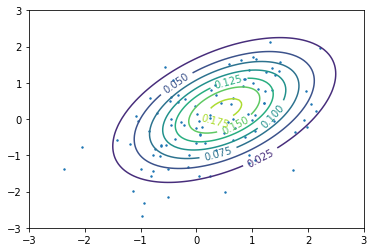

In [116]:
# generate meshgrid for plotting
xx, xy = np.meshgrid(*np.linspace(-3, 3, 100)[np.newaxis, :].repeat(2, 0))

# Need an (N, 2) array of (x, y) pairs.
x_new = np.column_stack([xx.flat, xy.flat])

# generate 
z = multivariate_normal.pdf(x_new, mean=mu, cov=cov)

print(z)

cs = plt.contour(xx, xy, z.reshape(100, 100))
plt.clabel(cs)
plt.scatter(x[:, 0], x[:, 1], s=2)

[[0.000225  ]
 [0.00026559]
 [0.00031184]
 ...
 [0.0008884 ]
 [0.00079802]
 [0.00071304]]


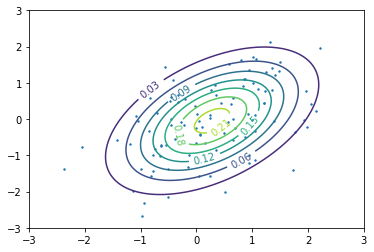

In [117]:
# generate meshgrid for plotting
xx, xy = np.meshgrid(*np.linspace(-3, 3, 100)[np.newaxis, :].repeat(2, 0))

# Need an (N, 2) array of (x, y) pairs.
x_new = np.column_stack([xx.flat, xy.flat])

z = mg.pdf(x_new)
print(z)

cs = plt.contour(xx, xy, z.reshape(100, 100))
plt.clabel(cs)
plt.scatter(x[:, 0], x[:, 1], s=2)

In [96]:
new_x = np.array([x1, x2]).T.reshape(-1, 2)
probs = mg.pdf(new_x)
print(probs.shape)
plt.contourf(x1, x2, probs.reshape(100, 100))

(10000, 2)


ValueError: cannot reshape array of size 20000 into shape (100,100)